# IA based CRO applied to Online Banking Selling Forms
Dataton Galicia 2019

Panuccio Abraham Alan

September of 2019

# Model Build - Optimization - Scoring

In [0]:
import numpy as np
import pandas as pd
#import custom_constants as cc
import copy
import itertools
from lightgbm import LGBMClassifier
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
import warnings
from google.colab import drive
from importlib.machinery import SourceFileLoader
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics.scorer import make_scorer
from sklearn import metrics
import sklearn.model_selection

BASE_PATH="/content/gdrive/My Drive/Tesis/"

drive.mount('/content/gdrive/')
cc = SourceFileLoader("custom_constants", BASE_PATH+"custom_constants.py").load_module()
cff = SourceFileLoader("custom_feature_selection", BASE_PATH+"custom_feature_selection.py").load_module()

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


## Model Build
To this project, we will use the __LightGBM's__ clasification algorithm and his __sklearn__ implementation. What's more we will test different models using differents features combinations, to see the __prediction's capability__ of each features group.

Then we will do a little hyperparameters' tunning for the best combinations and we will compare the AUC score from all of them in the private and public's score of __kaggle__.

At the end, we will be able to define the best __features-hyperparameters__ combination which got the best __private score__ in __kaggle__, so that will be the definitive model to predict the 1Q2019's loans convertions and we will compare that with the 1st, 2nd & 3rd competition's places.



### Traing model function

In [0]:
warnings.filterwarnings("ignore")

# User-defined function to train a model based on the parameters and write the output scoring including the Fimportances
def train_model(experiment, learner, data, train_months, test_months, apply_months, k_folds, k_seed, k_estoping):
    # Separate the months for train, test & apply for the entire dataset
    X_train = data[((data.MONTH.isin(train_months)))]
    X_test  = data[((data.MONTH.isin(test_months)))]
    X_apply = data[((data.MONTH.isin(apply_months)))]
    
    X_test2 = copy.copy(X_test)
    
    # Separate the months for train, test & apply for the target 
    y_train = pd.Series(X_train['TARGET'])
    y_test  = pd.Series(X_test ['TARGET'])
    y_apply = pd.Series(X_apply ['TARGET'])
    
    # Make a copy for the original apply dataset, to apply later the model
    X_apply_orig = copy.copy(X_apply)
    
    # Drop the target and index columns from the dependents features
    X_train.drop(["TARGET","USER_ID","MONTH"], axis=1, inplace=True)
    X_test.drop (["TARGET","USER_ID","MONTH"], axis=1, inplace=True)
    X_apply.drop(["TARGET","USER_ID","MONTH"], axis=1, inplace=True)
    
    # Train a model with the learner & k_folds indicated
    fi = []
    apply_probs = []
    test_probs = []
    i = 0
    for train_idx, valid_idx in model_selection.StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=k_seed).split(X_train, y_train):
        i += 1
        
        # Split the train & validation datasets with the cv fold ids
        Xt = X_train.iloc[train_idx]
        yt = y_train.loc[X_train.index].iloc[train_idx]
        Xv = X_train.iloc[valid_idx]
        yv = y_train.loc[X_train.index].iloc[valid_idx]

        learner.fit(Xt, yt,  early_stopping_rounds=k_estoping, eval_metric="auc", eval_set=[(Xt, yt), (Xv, yv)], verbose=0)

        # Union of all apply predictions to make the assembly later.
        apply_probs.append(pd.Series(learner.predict_proba(X_apply)[:, -1], index=X_apply.index, name="fold_" + str(i)))
        fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

        # Union of all test predictions to make the assembly later and know the AUC of the model trained
        test_probs.append(pd.Series(learner.predict_proba(X_test)[:, -1], index=X_test.index, name="fold_" + str(i)))
    
    # AUC score in a month which had never seen before
    test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
    test_probs.name="SCORE"
    test_probs=pd.DataFrame(test_probs)
    test_probs=test_probs.fillna(0)
    auc = roc_auc_score(y_test, test_probs["SCORE"])
    print("Experiment "+str(experiment)+" - AUC:"+str(auc))    
    
    # Get the final scoring result in the apply dataset
    apply_probs = pd.concat(apply_probs, axis=1).mean(axis=1)
    apply_probs.name="SCORE"
    apply_probs=pd.DataFrame(apply_probs)
    data_probs=data['USER_ID']
    data_probs2=pd.DataFrame(data['USER_ID'].drop_duplicates())
    data_probs2=data_probs2.set_index('USER_ID')
    apply_probs=apply_probs.merge(data_probs, how='left',left_index=True, right_index=True)
    apply_probs=apply_probs.set_index('USER_ID')
    apply_probs=data_probs2.merge(apply_probs, how='left',left_index=True, right_index=True)
    apply_probs=apply_probs.fillna(0)

    # Write the model's scoring results
    apply_probs.to_csv(BASE_PATH + cc.PATH_RESULTS+str(experiment)+"_scoring.csv", header=True)
    
    # Delete what I don't need
    del data_probs2, data_probs

    # Feature Importances
    df_varimp = pd.DataFrame({'Atributo':X_train.columns, 'importance': learner.feature_importances_ }).sort_values('importance',ascending=False)
    df_varimp.to_csv(BASE_PATH + cc.PATH_RESULTS+str(experiment)+"_fe_imp.csv", header=True, sep=";")
    
    # Order the predictions by USER_ID
    X_test2["SCORE"] = test_probs["SCORE"]
    X_test2 = X_test2.sort_values(by=["MONTH","USER_ID"])
    
    return auc, X_test2["SCORE"], df_varimp

In [0]:
# Configuration Constants
seed=19911125
folds=10
early_stoping=10

### Conversions Data Set
The first dataset to load is the conversions' dataset wich have the index columns (USER_ID, MONTH) and the TARGET.

In [0]:
dt_conv = pd.read_csv(BASE_PATH + cc.PATH_DT_CONVERSIONS)
dt_conv.drop(["Unnamed: 0"], axis=1, inplace=True)
dt_conv.head(5)

,USER_ID,MONTH,CONVERSION_L1,CONVERSION_L2,CONVERSION_L3,CONVERSION_CURR,CONVERSION_LU,TARGET
0,0,3,0.0,0.0,0.0,0.0,0.0,0
1,0,2,0.0,0.0,0.0,0.0,0.0,0
2,0,1,0.0,0.0,0.0,0.0,0.0,0
3,0,5,0.0,0.0,0.0,0.0,0.0,0
4,0,6,0.0,0.0,0.0,0.0,0.0,0


In [0]:
# I will create the truth conversions dataset for the target prediction, 
# it will be used in the curve ROC plot.
y_truth = dt_conv[dt_conv.MONTH==12]
y_truth = y_truth[["TARGET","USER_ID"]]
y_truth = y_truth.sort_values(by="USER_ID")
y_truth = y_truth["TARGET"]
y_truth.count()

11676

In [0]:
# I read the prediction's dataset for the 1st & 3rd places of the competition
y_pred_1st = pd.read_csv(BASE_PATH + cc.PATH_1ST_PLACE)
y_pred_1st = y_pred_1st.sort_values(by="USER_ID")
y_pred_1st = y_pred_1st["SCORE"]

y_pred_3rd = pd.read_csv(BASE_PATH + cc.PATH_3RD_PLACE)
y_pred_3rd = y_pred_3rd.sort_values(by="USER_ID")
y_pred_3rd = y_pred_3rd["SCORE"]

y_pred_3rd.count()

11676

### Competitions ROC Curves
We start looking the ROC Curve of the 1st & 3rd places of the competition, as a base-line for the thesis.

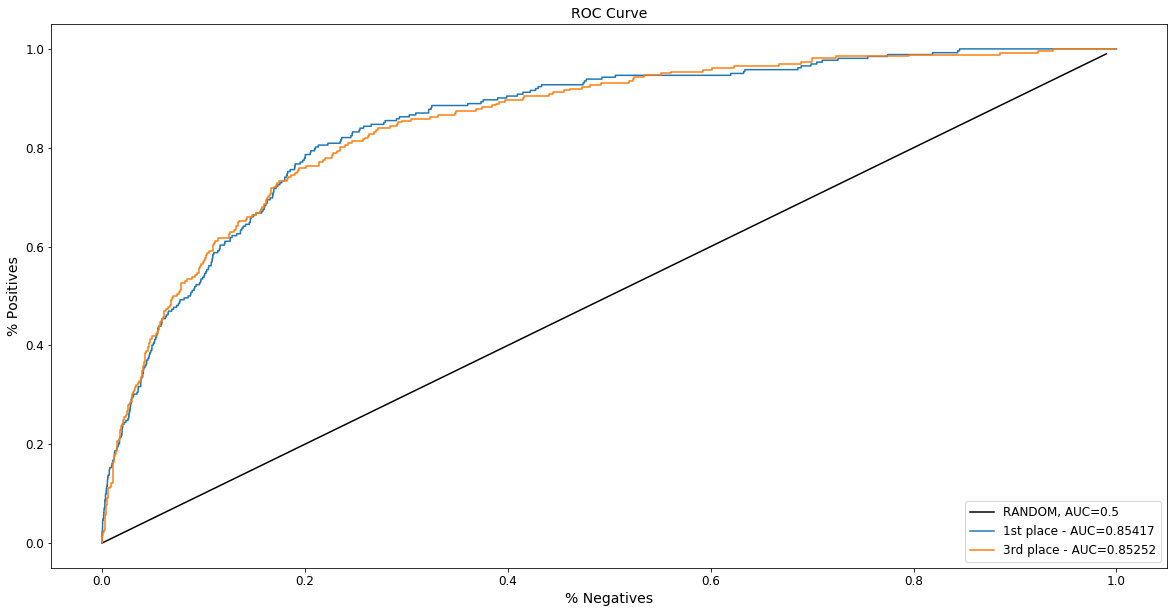

In [0]:
# Plot the ROC Curve for the 1st & 3rd places of the competition
cff.plot_roc_curves(y_truth, {"1st place - AUC=0.85417":y_pred_1st, "3rd place - AUC=0.85252":y_pred_3rd})

### 6 Months Time's Window Data Set
Next we continue to add the variables from the 6 months time's windows to the base dataset (conversions) and test to fit a modelo with those variables.
This experiment is named "0002".

In [0]:
dt_6m = pd.read_csv(BASE_PATH + cc.PATH_DT_6MONTHS)
dt_6m.drop(["Unnamed: 0"], axis=1, inplace=True)
dt_conv = dt_conv.merge(dt_6m, how='left', on=['USER_ID','MONTH'])
learner = LGBMClassifier(n_estimators=10000, random_state=seed, verbose=0)
auc, y_pred_6m, varimp_6m = train_model("0002", learner, dt_conv, cc.K_TRAINING_MONTHS, [12], [12], folds, seed, early_stoping)
dt_conv.head(5)

Experiment 0002 - AUC:0.8449791136370628


,USER_ID,MONTH,CONVERSION_L1,CONVERSION_L2,CONVERSION_L3,CONVERSION_CURR,CONVERSION_LU,TARGET,6M_PAGE_HIERARCHY_NUEVO_INICIO,6M_PAGE_HIERARCHY_UQ_ PAGOEXPRESO,6M_PAGE_HIERARCHY_UQ_ HOTSALE1,6M_PAGE_HIERARCHY_MODIFICAR-LIMITE-COMPRA,6M_PAGE_HIERARCHY_UQ_LOGINMER,6M_PAGE_HIERARCHY_UQ_194,6M_PAGE_HIERARCHY_CARGARMAIL,6M_CONTENT_CATEGORY_BOTTOM_UQ_2,6M_PAGE_HIERARCHY_UQ_ SACA TU TARJETA GALICIA,6M_PAGE_HIERARCHY_UQ_LICITAR,6M_ON_SITE_SEARCH_TERM_171,6M_PAGE_HIERARCHY_UQ_ SEGURO BICI GALICIA MOVE,6M_WEEKEND_WEEKEND,6M_PAGE_HIERARCHY_ RIESGOSPATRIMONIALES,6M_CONTENT_CATEGORY_59,6M_PAGE_HIERARCHY_UQ_INGRESAR-LIMITES-ADICIONALES,6M_CONTENT_CATEGORY_3,6M_PAGE_HIERARCHY_ SACA TU TARJETA GALICIA,6M_PAGE_HIERARCHY_ FONDOSFIMA,6M_PAGE_OWN_LOANS,6M_PAGE_HIERARCHY_UQ_ PLANESDECOMUNICACION,6M_PAGE_HIERARCHY_INICIONUEVOCONTACTOCONFIRMACION,6M_PAGE_HIERARCHY_ MERCADODECAPITALESYBANCADEINVER,6M_PAGE_HIERARCHY_MONTOPAGAR,6M_PAGE_HIERARCHY_UQ_173,6M_PAGE_HIERARCHY_UQ_88,6M_PAGE_HIERARCHY_PAGAR,6M_CONTENT_CATEGORY_27,6M_PAGE_HIERARCHY_ INVIERNO GALICIA PREFER,6M_PAGE_HIERARCHY_PREGUNTAS_PRESTAMOS,6M_PAGE_HIERARCHY_ SI,6M_PAGE_HIERARCHY_UQ_FUERADESERVICIO,...,6M_PAGE_HIERARCHY_EDITAR-CUENTA-PROYECTO-MONTO-OBJETIV,6M_PAGE_HIERARCHY_UQ_ PAGOS,6M_PAGE_HIERARCHY_SOLICITAR-HIPOTECARIO-PRECONFIRMACION,6M_PAGE_HIERARCHY_INGRESAR-ENTREGA-ADICIONALES,6M_WEEKEND_UQ_WEEK,6M_PAGE_HIERARCHY_ ERROR,6M_PAGE_HIERARCHY_UQ_ ESPECIALMARCAS,6M_PAGE_HIERARCHY_UQ_PREGUNTAS_PRESTAMOS,6M_PAGE_HIERARCHY_UQ_VISA-HOME,6M_PAGE_HIERARCHY_DEBITO-AUTOMATICO-DETENER,6M_PAGE_HIERARCHY_ BENEFICIOSPREFER,6M_PAGE_HIERARCHY_UQ_ YPFGAS,6M_PAGE_HIERARCHY_UQ_INGRESAR-ENTREGA-ADICIONALES,6M_PAGE_HIERARCHY_LOGINBOO,6M_PAGE_HIERARCHY_UQ_CONFIRMACIONRESERVA,6M_PAGE_HIERARCHY_ EMPLEOS,6M_PAGE_HIERARCHY_UQ_INICIOB,6M_PAGE_HIERARCHY_UQ_ LINEAPRODUCTIVAGALICIA,6M_PAGE_HIERARCHY_UQ_53,6M_PAGE_HIERARCHY_UQ_ERORIN,6M_PAGE_HIERARCHY_UQ_68,6M_CONTENT_CATEGORY_BOTTOM_UQ_11,6M_PAGE_HIERARCHY_ CUENTAPROPIA,6M_PAGE_OWN_UQ_TRANSFERS,6M_ON_SITE_SEARCH_TERM_UQ_16,6M_CONTENT_CATEGORY_TOP_UQ_2,6M_SITE_ID_UQ_1,6M_PAGE_HIERARCHY_CONFIRMACIONPAGO,6M_PAGE_HIERARCHY_ PREGUNTASFRECUENTES,6M_PAGE_HIERARCHY_LICITAR-MONTO,6M_SITE_ID_UQ_4,6M_CONTENT_CATEGORY_BOTTOM_13,6M_ON_SITE_SEARCH_TERM_UQ_1,6M_PAGE_HIERARCHY_UQ_SALDOSPENDIENTES,6M_PAGE_HIERARCHY_UQ_SOLICITAR-HIPOTECARIO-AGREGAR-SOLICITANTE,6M_PAGE_HIERARCHY_ DIADELPADRE,6M_PAGE_HIERARCHY_UQ_ ERROR E,6M_PAGE_HIERARCHY_CONFIRMACIONREPOSICION,6M_PAGE_HIERARCHY_ FORM CHARLA INFORMATIVA,6M_PAGE_HIERARCHY_UQ_ CLAVE GALICIA BLOQUEADA
0,0,3,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,35.0,0.0,0.0,0.0,NaN,7061.0,NaN,NaN,0.0,54.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,50.0,NaN,0.0,55.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,7.0,0.0,66.0,50.0,109.0,0.0,0.0,0.0,0.0,67.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN
1,0,2,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,13.0,0.0,0.0,0.0,NaN,6359.0,NaN,NaN,0.0,92.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,36.0,NaN,0.0,37.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,2.0,0.0,44.0,35.0,0.0,0.0,0.0,0.0,0.0,45.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2,0,1,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,7.0,0.0,0.0,0.0,NaN,4789.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,23.0,NaN,0.0,21.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,1.0,0.0,25.0,22.0,0.0,0.0,0.0,0.0,0.0,26.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN
3,0,5,0.0,0.0,0.0,0.0,0.0,0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,75.0,0.0,0.0,0.0,NaN,8186.0,NaN,0.0,0.0,35.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,70.0,NaN,0.0,89.0,0.0,0.0,0.0,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,NaN,8.0,0.0,106.0,69.0,71.0,0.0,0.0,0.0,0.0,107.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN
4,0,6,0.0,0.0,0.0,0.0,0.0,0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,88.0,0.0,0.0,0.0,0.0,8866.0,NaN,0.0,0.0,31.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.

#### Feature Importances

In [0]:
# Show the variable importances for the model built
varimp_6m.head(20)

,Atributo,importance
751,6M_PAGE_OWN_PLOANS,78
37,6M_PAGE_HIERARCHY_0,76
357,6M_PAGE_HIERARCHY_LOGIN,71
318,6M_PAGE_HIERARCHY_MIS-CUENTAS,65
38,6M_PAGE_HIERARCHY_VISA-HOME,65
382,6M_PAGE_OWN_LOG,60
647,6M_PAGE_HIERARCHY_ERRORIN,59
497,6M_PAGE_HIERARCHY_1,58
202,6M_PAGE_HIERARCHY_INICIOTOKEN,55
575,6M_PAGE_HIERARCHY_PAGO-MIS-CUENTAS,54


#### AUC y Curva ROC

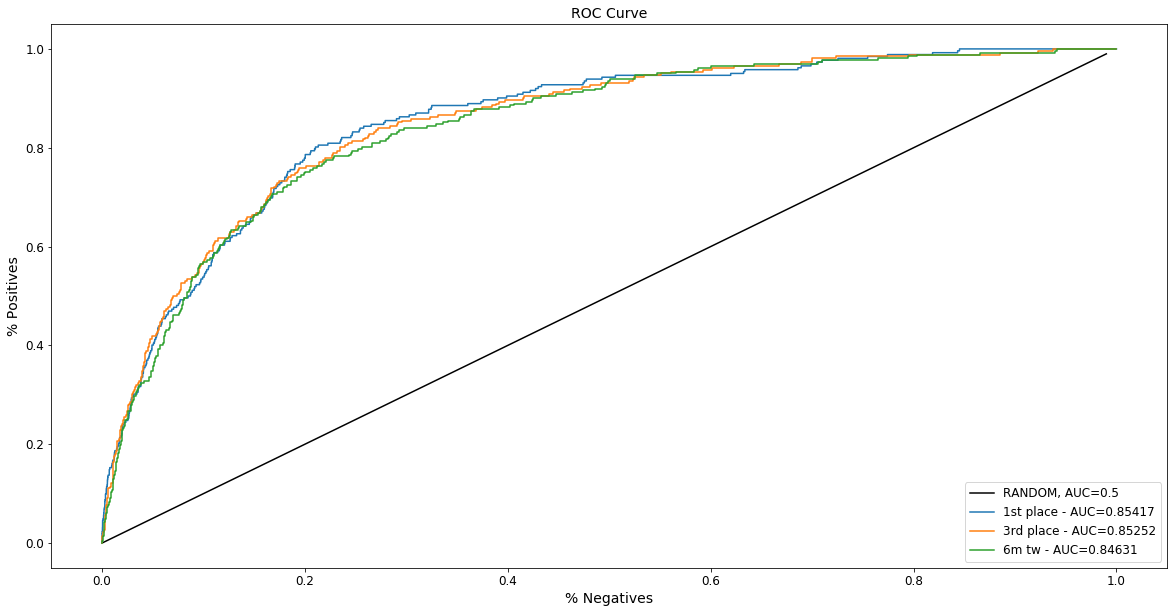

In [0]:
# Plot the ROC Curve for the 1st & 3rd places of the competition
cff.plot_roc_curves(y_truth, {"1st place - AUC=0.85417":y_pred_1st, "3rd place - AUC=0.85252":y_pred_3rd, "6m tw - AUC=0.84631": y_pred_6m})

### 4 Months Time's Window Data Set
Next we continue to add the variables from the 4 months time's windows to the acum dataset and test to fit a modelo with those variables.
This experiment is named "0003".

In [0]:
dt_4m = pd.read_csv(BASE_PATH + cc.PATH_DT_4MONTHS)
dt_4m.drop(["Unnamed: 0"], axis=1, inplace=True)
dt_conv = dt_conv.merge(dt_4m, how='left', on=['USER_ID','MONTH'])
learner = LGBMClassifier(n_estimators=10000, random_state=seed, verbose=0)
auc, y_pred_6_4m, varimp_6_4m = train_model("0003", learner, dt_conv, cc.K_TRAINING_MONTHS, [12], [12], folds, seed, early_stoping)
dt_conv.head(5)

Experiment 0003 - AUC:0.8505103549009722


,USER_ID,MONTH,CONVERSION_L1,CONVERSION_L2,CONVERSION_L3,CONVERSION_CURR,CONVERSION_LU,TARGET,6M_PAGE_HIERARCHY_NUEVO_INICIO,6M_PAGE_HIERARCHY_UQ_ PAGOEXPRESO,6M_PAGE_HIERARCHY_UQ_ HOTSALE1,6M_PAGE_HIERARCHY_MODIFICAR-LIMITE-COMPRA,6M_PAGE_HIERARCHY_UQ_LOGINMER,6M_PAGE_HIERARCHY_UQ_194,6M_PAGE_HIERARCHY_CARGARMAIL,6M_CONTENT_CATEGORY_BOTTOM_UQ_2,6M_PAGE_HIERARCHY_UQ_ SACA TU TARJETA GALICIA,6M_PAGE_HIERARCHY_UQ_LICITAR,6M_ON_SITE_SEARCH_TERM_171,6M_PAGE_HIERARCHY_UQ_ SEGURO BICI GALICIA MOVE,6M_WEEKEND_WEEKEND,6M_PAGE_HIERARCHY_ RIESGOSPATRIMONIALES,6M_CONTENT_CATEGORY_59,6M_PAGE_HIERARCHY_UQ_INGRESAR-LIMITES-ADICIONALES,6M_CONTENT_CATEGORY_3,6M_PAGE_HIERARCHY_ SACA TU TARJETA GALICIA,6M_PAGE_HIERARCHY_ FONDOSFIMA,6M_PAGE_OWN_LOANS,6M_PAGE_HIERARCHY_UQ_ PLANESDECOMUNICACION,6M_PAGE_HIERARCHY_INICIONUEVOCONTACTOCONFIRMACION,6M_PAGE_HIERARCHY_ MERCADODECAPITALESYBANCADEINVER,6M_PAGE_HIERARCHY_MONTOPAGAR,6M_PAGE_HIERARCHY_UQ_173,6M_PAGE_HIERARCHY_UQ_88,6M_PAGE_HIERARCHY_PAGAR,6M_CONTENT_CATEGORY_27,6M_PAGE_HIERARCHY_ INVIERNO GALICIA PREFER,6M_PAGE_HIERARCHY_PREGUNTAS_PRESTAMOS,6M_PAGE_HIERARCHY_ SI,6M_PAGE_HIERARCHY_UQ_FUERADESERVICIO,...,4M_PAGE_HIERARCHY_0,4M_PAGE_HIERARCHY_TARJETA-COORDENADAS,4M_PAGE_HIERARCHY_TOKEN-VIRTUAL,4M_PAGE_HIERARCHY_UPGRADE,4M_PAGE_OWN_UQ_LOG,4M_PAGE_HIERARCHY_SOLICITAR-HIPOTECARIO-SELECCIONAR-SUBTIPO,4M_PAGE_HIERARCHY_UQ_INICIOTOKEN,4M_CONTENT_CATEGORY_BOTTOM_UQ_1,4M_HOLIDAY_LOANS_NOT_HOLIDAY,4M_PAGE_HIERARCHY_UQ_DEBITO-AUTOMATICO-EDITAR,4M_PAGE_HIERARCHY_UQ_PRECALCULOVENTADOLARES,4M_HOLIDAY_LOANS_HOLIDAY_PLOANS,4M_PAGE_HIERARCHY_UQ_0,4M_PAGE_HIERARCHY_UQ_ HOME,4M_PAGE_HIERARCHY_LICITAR-CONTACTO,4M_PAGE_HIERARCHY_ NOENCONTRADA,4M_PAGE_HIERARCHY_UQ_PAGAR,4M_PAGE_HIERARCHY_SOLICITAR-HIPOTECARIO-PRECONFIRMACION,4M_PAGE_HIERARCHY_UQ_TERCEROS-EXITO,4M_HOLIDAY_OPEN_UQ_BEFORE_HOLIDAY,4M_PAGE_HIERARCHY_LICITAR-MONTO,4M_PAGE_HIERARCHY_UQ_SOLICITAR-EXITO,4M_PAGE_HIERARCHY_SELECCIONARTARJETAREPOSICION-DELIVERY,4M_ON_SITE_SEARCH_TERM_UQ_1,4M_PAGE_HIERARCHY_SOLICITAR-SELECCIONAR-CUENTAS,4M_PAGE_HIERARCHY_UQ_SOLICITAR-HIPOTECARIO-OFERTA,4M_PAGE_HIERARCHY_ ERROR NO MANEJADO,4M_PAGE_HIERARCHY_UQ_1,4M_PAGE_HIERARCHY_SOLICITAR_SELECCIONAR_SUBTIPO_PRESTAMO_PER,4M_PAGE_HIERARCHY_CUENTAS-PROPIAS,4M_PAGE_HIERARCHY_ PRESTAMOS PERSONALES UVA EMINEN,4M_PAGE_HIERARCHY_RECARGAR-CELULAR-MONTO,4M_WEEKEND_UQ_WEEKEND,4M_PAGE_HIERARCHY_MONTOPAGAR,4M_PAGE_HIERARCHY_ ESTADO DE SOLICITUDES,4M_HOLIDAY_LOANS_UQ_NOT_HOLIDAY,4M_PAGE_HIERARCHY_PRECONFIRMACIONPAGO,4M_PAGE_HIERARCHY_CARGARMONTOOBJETIVO,4M_PAGE_HIERARCHY_UPGRADE-CONTACTO,4M_PAGE_HIERARCHY_RECARGAR-CELULAR-NUMERO
0,0,3,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,35.0,0.0,0.0,0.0,NaN,7061.0,NaN,NaN,0.0,54.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,...,109.0,54.0,0.0,0.0,66.0,NaN,2.0,50.0,100000.0,0.0,0.0,0.0,2.0,6.0,0.0,54.0,0.0,NaN,0.0,6.0,0.0,0.0,NaN,67.0,0.0,NaN,0.0,0.0,NaN,217.0,0.0,0.0,12.0,0.0,0.0,67.0,109.0,0.0,0.0,0.0
1,0,2,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,13.0,0.0,0.0,0.0,NaN,6359.0,NaN,NaN,0.0,92.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,...,92.0,0.0,0.0,0.0,44.0,NaN,1.0,35.0,100000.0,0.0,0.0,0.0,1.0,5.0,0.0,92.0,0.0,NaN,0.0,5.0,0.0,0.0,NaN,45.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,8.0,0.0,0.0,45.0,0.0,0.0,0.0,0.0
2,0,1,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,7.0,0.0,0.0,0.0,NaN,4789.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,...,141.0,0.0,0.0,0.0,25.0,NaN,0.0,22.0,100000.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,NaN,0.0,2.0,0.0,0.0,NaN,26.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,5.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0
3,0,5,0.0,0.0,0.0,0.0,0.0,0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,75.0,0.0,0.0,0.0,NaN,8186.0,NaN,0.0,0.0,35.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,235.0,47.0,0.0,0.0,81.0,NaN,2.0,47.0,100000.0,0.0,0.0,0.0,4.0,4.0,0.0,47.0,0.0,NaN,1.0,7.0,0.0,0.0,0.0,81.0,0.0,NaN,0.0,0.0,0.0,188.0,0.0,0.0,13.0,0.0,0.0,81.0,94.0,0.0,0.0,0.0
4,0,6,0.0,0.0,0.0,0.0,0.0,0,0.0,Na

#### Feature Importances

In [0]:
# Show the variable importances for the model built
varimp_6_4m.head(20)

,Atributo,importance
751,6M_PAGE_OWN_PLOANS,38
1025,4M_PAGE_HIERARCHY_0,33
181,6M_PAGE_OWN_UQ_INVESTMENTS,28
318,6M_PAGE_HIERARCHY_MIS-CUENTAS,28
437,6M_CONTENT_CATEGORY_TOP_1,27
986,4M_PAGE_HIERARCHY_ERRORIN,23
357,6M_PAGE_HIERARCHY_LOGIN,22
38,6M_PAGE_HIERARCHY_VISA-HOME,22
337,6M_HOLIDAY_OPEN_HOLIDAY,22
142,6M_PAGE_HIERARCHY_COMPRA-DOLARES,22


#### AUC y Curva ROC

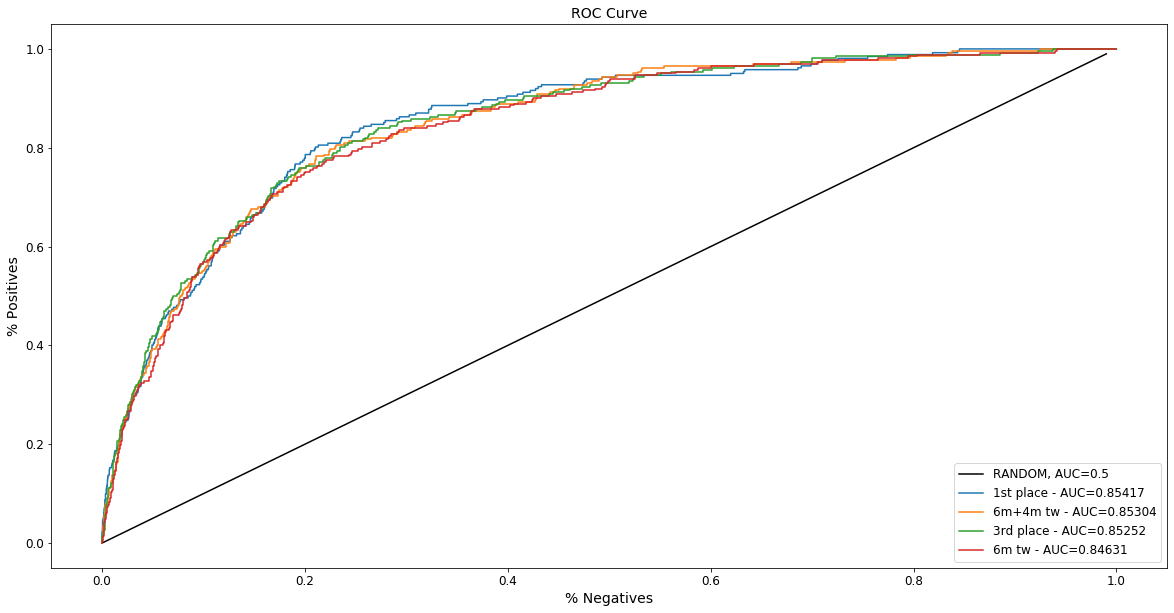

In [0]:
# Plot the ROC Curve for the 1st & 3rd places of the competition
cff.plot_roc_curves(y_truth, {"1st place - AUC=0.85417":y_pred_1st, "6m+4m tw - AUC=0.85304": y_pred_6_4m, "3rd place - AUC=0.85252":y_pred_3rd, "6m tw - AUC=0.84631": y_pred_6m})

### 4 vs 6 Months Trends Data Set
Next we continue to add the trends variables dataset which compare the  4 months and 6 months time's windows to the acum dataset and test to fit a modelo with those variables.
This experiment is named "0004".

In [0]:
dt_36m = pd.read_csv(BASE_PATH + cc.PATH_DT_4M_6M)
dt_36m.drop(["Unnamed: 0"], axis=1, inplace=True)
dt_conv = dt_conv.merge(dt_36m, how='left', on=['USER_ID','MONTH'])
learner = LGBMClassifier(n_estimators=10000, random_state=seed, verbose=0)
auc, y_pred_6_4_4v6m, varimp_6_4_4v6m = train_model("0004", learner, dt_conv, cc.K_TRAINING_MONTHS, [12], [12], folds, seed, early_stoping)
dt_conv.head(5)

Experiment 0004 - AUC:0.8468567461681583


,USER_ID,MONTH,CONVERSION_L1,CONVERSION_L2,CONVERSION_L3,CONVERSION_CURR,CONVERSION_LU,TARGET,6M_PAGE_HIERARCHY_NUEVO_INICIO,6M_PAGE_HIERARCHY_UQ_ PAGOEXPRESO,6M_PAGE_HIERARCHY_UQ_ HOTSALE1,6M_PAGE_HIERARCHY_MODIFICAR-LIMITE-COMPRA,6M_PAGE_HIERARCHY_UQ_LOGINMER,6M_PAGE_HIERARCHY_UQ_194,6M_PAGE_HIERARCHY_CARGARMAIL,6M_CONTENT_CATEGORY_BOTTOM_UQ_2,6M_PAGE_HIERARCHY_UQ_ SACA TU TARJETA GALICIA,6M_PAGE_HIERARCHY_UQ_LICITAR,6M_ON_SITE_SEARCH_TERM_171,6M_PAGE_HIERARCHY_UQ_ SEGURO BICI GALICIA MOVE,6M_WEEKEND_WEEKEND,6M_PAGE_HIERARCHY_ RIESGOSPATRIMONIALES,6M_CONTENT_CATEGORY_59,6M_PAGE_HIERARCHY_UQ_INGRESAR-LIMITES-ADICIONALES,6M_CONTENT_CATEGORY_3,6M_PAGE_HIERARCHY_ SACA TU TARJETA GALICIA,6M_PAGE_HIERARCHY_ FONDOSFIMA,6M_PAGE_OWN_LOANS,6M_PAGE_HIERARCHY_UQ_ PLANESDECOMUNICACION,6M_PAGE_HIERARCHY_INICIONUEVOCONTACTOCONFIRMACION,6M_PAGE_HIERARCHY_ MERCADODECAPITALESYBANCADEINVER,6M_PAGE_HIERARCHY_MONTOPAGAR,6M_PAGE_HIERARCHY_UQ_173,6M_PAGE_HIERARCHY_UQ_88,6M_PAGE_HIERARCHY_PAGAR,6M_CONTENT_CATEGORY_27,6M_PAGE_HIERARCHY_ INVIERNO GALICIA PREFER,6M_PAGE_HIERARCHY_PREGUNTAS_PRESTAMOS,6M_PAGE_HIERARCHY_ SI,6M_PAGE_HIERARCHY_UQ_FUERADESERVICIO,...,TREND36_CONTENT_CATEGORY_BOTTOM_11,TREND36_PAGE_OWN_REQUEST_LOAN,TREND36_PAGE_HIERARCHY_TERCEROS-CBU,TREND36_PAGE_HIERARCHY_0,TREND36_PAGE_HIERARCHY_ PRESTAMOS HIPOTECARIOS UVA,TREND36_WEEKEND_UQ_WEEKEND,TREND36_PAGE_HIERARCHY_UQ_ERROROUT,TREND36_PAGE_HIERARCHY_INICIO,TREND36_PAGE_OWN_PLOANS,TREND36_PAGE_HIERARCHY_UQ_TARJETA-COORDENADAS,TREND36_PAGE_HIERARCHY_ERRORIN,TREND36_PAGE_HIERARCHY_TODO-PAGO,TREND36_PAGE_HIERARCHY_ ERROR NO MANEJADO,TREND36_PAGE_HIERARCHY_SOLICITAR_SELECCIONAR_SUBTIPO_PRESTAMO_PER,TREND36_PAGE_HIERARCHY_UQ_SOLICITAR-EXITO,TREND36_PAGE_HIERARCHY_SOLICITAR-HIPOTECARIO-OFERTA,TREND36_PAGE_HIERARCHY_SELECCIONARTARJETAREPOSICION-DELIVERY,TREND36_PAGE_HIERARCHY_UQ_ PRESTAMOS,TREND36_HOLIDAY_OPEN_UQ_NOT_HOLIDAY,TREND36_PAGE_HIERARCHY_UQ_CONFIRMARCUENTASPROPIAS,TREND36_PAGE_HIERARCHY_UQ_UPGRADE-ENTREGA,TREND36_PAGE_HIERARCHY_SOLICITAR-PRECONFIRMACION,TREND36_HOLIDAY_LOANS_UQ_NOT_HOLIDAY,TREND36_PAGE_HIERARCHY_UQ_SOLICITAR-PRECONFIRMACION,TREND36_PAGE_HIERARCHY_ PREGUNTASFRECUENTES,TREND36_PAGE_HIERARCHY_PRECONFIRMACIONRECARGACELULAR,TREND36_PAGE_HIERARCHY_UQ_PAGO-MIS-CUENTAS,TREND36_PAGE_HIERARCHY_UQ_NUEVO_INICIO,TREND36_CONTENT_CATEGORY_BOTTOM_UQ_16,TREND36_PAGE_HIERARCHY_UQ_SOLICITAR-HIPOTECARIO-AGREGAR-SOLICITANTE,TREND36_PAGE_HIERARCHY_PRECONFIRMARCUENTASPROPIAS,TREND36_PAGE_HIERARCHY_UQ_SOLICITAR-HIPOTECARIO-SELECCIONAR-DESTINO,TREND36_PAGE_HIERARCHY_UQ_SOLICITAR-SELECCIONAR-TIPO-PRESTAMO,TREND36_HOLIDAY_LOANS_HOLIDAY_REQUEST_LOAN,TREND36_PAGE_HIERARCHY_UPGRADE-PRECONFIRMACION,TREND36_PAGE_HIERARCHY_CONFIRMACIONRECARGACELULAR,TREND36_PAGE_HIERARCHY_UQ_PRECALCULOVENTADOLARES,TREND36_PAGE_HIERARCHY_UPGRADE,TREND36_PAGE_HIERARCHY_1,TREND36_SITE_ID_UQ_2
0,0,3,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,35.0,0.0,0.0,0.0,NaN,7061.0,NaN,NaN,0.0,54.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,15.0,NaN,10.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,13.0,NaN,NaN,15.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0
1,0,2,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,13.0,0.0,0.0,0.0,NaN,6359.0,NaN,NaN,0.0,92.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,15.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0
2,0,1,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,7.0,0.0,0.0,0.0,NaN,4789.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,14.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0
3,0,5,0.0,0.0,0.0,0.0,0.0,0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,75.0,0.0,0.0,0.0,NaN,8186.0,NaN,0.0,0.0,35.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

#### Feature Importances

In [0]:
# Show the variable importances for the model built
varimp_6_4_4v6m.head(20)

,Atributo,importance
1025,4M_PAGE_HIERARCHY_0,42
751,6M_PAGE_OWN_PLOANS,39
357,6M_PAGE_HIERARCHY_LOGIN,35
37,6M_PAGE_HIERARCHY_0,34
318,6M_PAGE_HIERARCHY_MIS-CUENTAS,34
986,4M_PAGE_HIERARCHY_ERRORIN,33
38,6M_PAGE_HIERARCHY_VISA-HOME,32
459,6M_PAGE_HIERARCHY_INICIO,30
437,6M_CONTENT_CATEGORY_TOP_1,29
273,6M_PAGE_OWN_UQ_PLOANS,27


#### AUC y Curva ROC

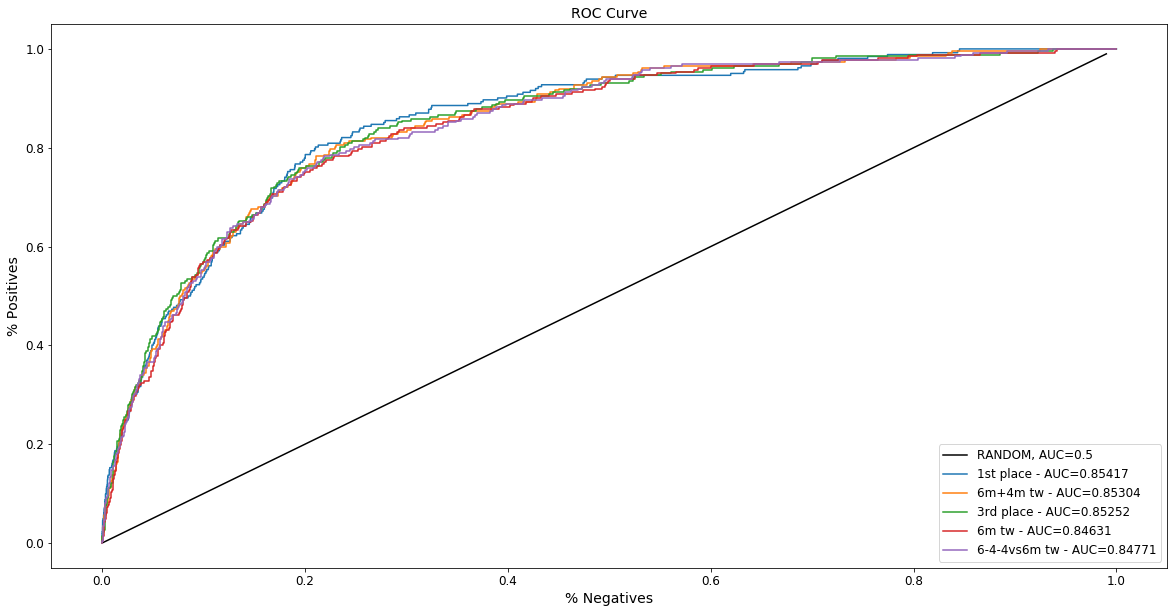

In [0]:
# Plot the ROC Curve for the 1st & 3rd places of the competition
cff.plot_roc_curves(y_truth, {"1st place - AUC=0.85417":y_pred_1st, "6m+4m tw - AUC=0.85304": y_pred_6_4m, "3rd place - AUC=0.85252":y_pred_3rd, "6m tw - AUC=0.84631": y_pred_6m, "6-4-4vs6m tw - AUC=0.84771": y_pred_6_4_4v6m})

### 5 Months Time's Window Data Set
Next we continue to add the variables from the 5 months time's windows to the acum dataset and test to fit a modelo with those variables.
This experiment is named "0005".

In [0]:
dt_5m = pd.read_csv(BASE_PATH + cc.PATH_DT_5MONTHS)
dt_5m.drop(["Unnamed: 0"], axis=1, inplace=True)
dt_conv = dt_conv.merge(dt_5m, how='left', on=['USER_ID','MONTH'])
learner = LGBMClassifier(n_estimators=10000, random_state=seed, verbose=0)
auc, y_pred_best_model, varimp_best_model  = train_model("0005", learner, dt_conv, cc.K_TRAINING_MONTHS, [12], [12], folds, seed, early_stoping)
dt_conv.head(5)

Experiment 0005 - AUC:0.853843278042099


,USER_ID,MONTH,CONVERSION_L1,CONVERSION_L2,CONVERSION_L3,CONVERSION_CURR,CONVERSION_LU,TARGET,6M_PAGE_HIERARCHY_NUEVO_INICIO,6M_PAGE_HIERARCHY_UQ_ PAGOEXPRESO,6M_PAGE_HIERARCHY_UQ_ HOTSALE1,6M_PAGE_HIERARCHY_MODIFICAR-LIMITE-COMPRA,6M_PAGE_HIERARCHY_UQ_LOGINMER,6M_PAGE_HIERARCHY_UQ_194,6M_PAGE_HIERARCHY_CARGARMAIL,6M_CONTENT_CATEGORY_BOTTOM_UQ_2,6M_PAGE_HIERARCHY_UQ_ SACA TU TARJETA GALICIA,6M_PAGE_HIERARCHY_UQ_LICITAR,6M_ON_SITE_SEARCH_TERM_171,6M_PAGE_HIERARCHY_UQ_ SEGURO BICI GALICIA MOVE,6M_WEEKEND_WEEKEND,6M_PAGE_HIERARCHY_ RIESGOSPATRIMONIALES,6M_CONTENT_CATEGORY_59,6M_PAGE_HIERARCHY_UQ_INGRESAR-LIMITES-ADICIONALES,6M_CONTENT_CATEGORY_3,6M_PAGE_HIERARCHY_ SACA TU TARJETA GALICIA,6M_PAGE_HIERARCHY_ FONDOSFIMA,6M_PAGE_OWN_LOANS,6M_PAGE_HIERARCHY_UQ_ PLANESDECOMUNICACION,6M_PAGE_HIERARCHY_INICIONUEVOCONTACTOCONFIRMACION,6M_PAGE_HIERARCHY_ MERCADODECAPITALESYBANCADEINVER,6M_PAGE_HIERARCHY_MONTOPAGAR,6M_PAGE_HIERARCHY_UQ_173,6M_PAGE_HIERARCHY_UQ_88,6M_PAGE_HIERARCHY_PAGAR,6M_CONTENT_CATEGORY_27,6M_PAGE_HIERARCHY_ INVIERNO GALICIA PREFER,6M_PAGE_HIERARCHY_PREGUNTAS_PRESTAMOS,6M_PAGE_HIERARCHY_ SI,6M_PAGE_HIERARCHY_UQ_FUERADESERVICIO,...,5M_PAGE_HIERARCHY_UQ_PRECONFIRMARCUENTASPROPIAS,5M_CONTENT_CATEGORY_UQ_2,5M_WEEKEND_UQ_WEEK,5M_PAGE_HIERARCHY_SOLICITAR-SELECCIONAR-TIPO-PRESTAMO,5M_PAGE_HIERARCHY_SOLICITAR-HIPOTECARIO-SELECCIONAR-SUBTIPO,5M_PAGE_HIERARCHY_UQ_1,5M_HOLIDAY_LOANS_UQ_HOLIDAY_REQUEST_LOAN,5M_PAGE_HIERARCHY_PREGUNTAS_PRESTAMOS,5M_PAGE_OWN_PLOANS,5M_PAGE_HIERARCHY_UQ_SOLICITAR-SELECCIONAR-TIPO-PRESTAMO,5M_PAGE_HIERARCHY_UQ_SESIONEXPIRADA,5M_HOLIDAY_OPEN_UQ_NOT_HOLIDAY,5M_PAGE_HIERARCHY_UQ_SOLICITAR,5M_PAGE_HIERARCHY_SOLICITAR,5M_CONTENT_CATEGORY_BOTTOM_UQ_2,5M_PAGE_HIERARCHY_UQ_INICIOTOKEN,5M_PAGE_HIERARCHY_ PRESTAMO,5M_CONTENT_CATEGORY_UQ_6,5M_SITE_ID_3,5M_PAGE_HIERARCHY_ PRESTAMOS PERSONALES BANCO GALI,5M_CONTENT_CATEGORY_16,5M_PAGE_HIERARCHY_UQ_SOLICITAR-SELECCIONAR-SUBTIPO-PRESTAMO,5M_PAGE_HIERARCHY_VISA-HOME,5M_PAGE_HIERARCHY_UQ_CONFIRMACIONPAGO,5M_SITE_ID_UQ_3,5M_PAGE_HIERARCHY_UQ_SOLICITAR-HIPOTECARIO-OFERTA,5M_PAGE_HIERARCHY_ERRORIN,5M_PAGE_OWN_UQ_TRANSFERS,5M_PAGE_OWN_REQUEST_LOAN,5M_PAGE_HIERARCHY_UQ_SOLICITAR-SELECCIONAR-SUBTIPO-PRESTAMO-PER,5M_PAGE_HIERARCHY_UQ_SOLICITAR-SELECCIONAR-CUENTAS,5M_PAGE_HIERARCHY_SOLICITAR-SELECCIONAR-SUBTIPO-PRESTAMO,5M_CONTENT_CATEGORY_BOTTOM_UQ_6,5M_PAGE_OWN_UQ_PLOANS,5M_HOLIDAY_UNIFIED_UQ_HOLIDAY,5M_HOLIDAY_LOANS_UQ_HOLIDAY_PLOANS,5M_PAGE_HIERARCHY_SOLICITAR-HIPOTECARIO-OFERTA,5M_PAGE_HIERARCHY_UQ_ERRORIN,5M_PAGE_HIERARCHY_UQ_SOLICITAR-HIPOTECARIO-AGREGAR-INGRESOS,5M_PAGE_HIERARCHY_UQ_ PRESTAMOS
0,0,3,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,35.0,0.0,0.0,0.0,NaN,7061.0,NaN,NaN,0.0,54.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,...,1.0,35.0,55.0,0.0,NaN,0.0,0.0,0.0,54.0,0.0,2.0,46.0,0.0,0.0,35.0,2.0,0.0,4.0,9397.0,0.0,0.0,0.0,0.0,1.0,12.0,NaN,54.0,7.0,0.0,0.0,0.0,0.0,4.0,1.0,21.0,0.0,NaN,1.0,NaN,0.0
1,0,2,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,13.0,0.0,0.0,0.0,NaN,6359.0,NaN,NaN,0.0,92.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,13.0,37.0,0.0,NaN,0.0,0.0,0.0,92.0,0.0,0.0,27.0,0.0,0.0,13.0,1.0,0.0,1.0,3594.0,0.0,0.0,0.0,0.0,0.0,3.0,NaN,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,18.0,0.0,NaN,0.0,NaN,0.0
2,0,1,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,7.0,0.0,0.0,0.0,NaN,4789.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,7.0,21.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,17.0,0.0,0.0,7.0,0.0,0.0,1.0,2254.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN,0.0,1.0,0.0,NaN,0.0,0.0,1.0,0.0,9.0,0.0,NaN,0.0,NaN,0.0
3,0,5,0.0,0.0,0.0,0.0,0.0,0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,75.0,0.0,0.0,0.0,NaN,8186.0,NaN,0.0,0.0,35.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,75.0,89.0,0.0,NaN,0.0,0.0,0.0,35.0,0.0,2.0,74.0,0.0,0.0,75.0,2.0,0.0,4.0,8398.0,0.0,0.0,0.0,71.0,1.0,21.0,NaN,71.0,8.0,0.0,0.0,0.0,0.0,4.0,1.0,33.0,0.0,NaN,2.0,NaN,0.0
4,0,6,0.0,0.0,0.0,0.0,0.0,0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,88.0,0.0,0.0

#### Feature Importances

In [0]:
# Show the variable importances for the model built
varimp_best_model.head(20)

,Atributo,importance
318,6M_PAGE_HIERARCHY_MIS-CUENTAS,25
1025,4M_PAGE_HIERARCHY_0,22
357,6M_PAGE_HIERARCHY_LOGIN,20
751,6M_PAGE_OWN_PLOANS,19
181,6M_PAGE_OWN_UQ_INVESTMENTS,19
755,6M_PAGE_HIERARCHY_ MOVI,17
142,6M_PAGE_HIERARCHY_COMPRA-DOLARES,17
155,6M_CONTENT_CATEGORY_TOP_5,16
37,6M_PAGE_HIERARCHY_0,15
476,6M_PAGE_OWN_TRANSFERS,15


#### AUC y Curva ROC

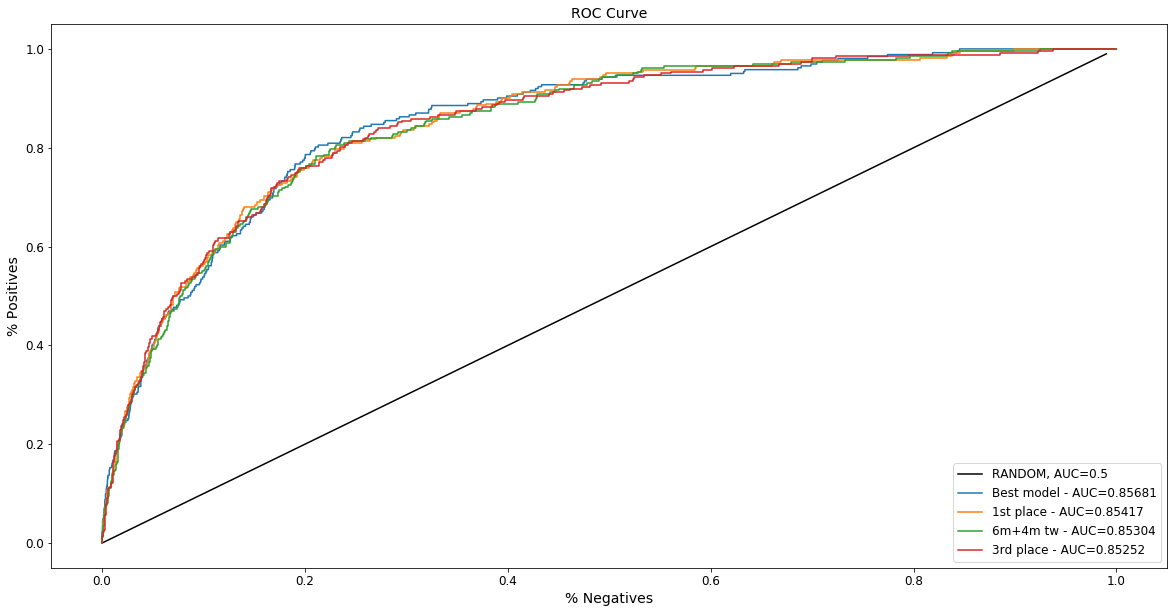

In [0]:
# Plot the ROC Curve for the 1st & 3rd places of the competition
#cff.plot_roc_curves(y_truth, {"Best model - AUC=0.85681": y_pred_best_model, "1st place - AUC=0.85417":y_pred_1st, "6m+4m tw - AUC=0.85304": y_pred_6_4m, "3rd place - AUC=0.85252":y_pred_3rd} )
cff.plot_roc_curves(y_truth, {"Best model - AUC=0.85681": y_pred_1st, "1st place - AUC=0.85417":y_pred_best_model, "6m+4m tw - AUC=0.85304": y_pred_6_4m, "3rd place - AUC=0.85252":y_pred_3rd} )

## Hyperparameters Optimization
Now we will test differents hyperparameters' combinations and generate differtens scorings output to test in the competition.

In [0]:
vestimators=[50,100,150,500,1000]
vdepth=[20,30,40,50]
parameters = itertools.product(vestimators, vdepth)

for p in parameters:
  learner = LGBMClassifier(n_estimators=p[0], max_depth=p[1], random_state=seed, verbose=0)
  auc = train_model("0005_"+str(p[1])+"_"+str(p[0]), learner, dt_conv, cc.K_TRAINING_MONTHS, [12], [12], folds, seed, early_stoping)

In [0]:
p = [100, 20]
learner = LGBMClassifier(n_estimators=p[0], max_depth=p[1], random_state=seed, verbose=0)
auc, best_model_hpo, varimp_best_model_hpo = train_model("best_model_HPO", learner, dt_conv, cc.K_TRAINING_MONTHS, [12], [12], folds, seed, early_stoping)

Experiment best_model_HPO - AUC:0.855803840736634


### Feature Importances

In [0]:
# Show the variable importances for the model built
varimp_best_model_hpo.head(20)

,Atributo,importance
318,6M_PAGE_HIERARCHY_MIS-CUENTAS,25
1025,4M_PAGE_HIERARCHY_0,22
357,6M_PAGE_HIERARCHY_LOGIN,20
751,6M_PAGE_OWN_PLOANS,19
181,6M_PAGE_OWN_UQ_INVESTMENTS,19
755,6M_PAGE_HIERARCHY_ MOVI,17
142,6M_PAGE_HIERARCHY_COMPRA-DOLARES,17
155,6M_CONTENT_CATEGORY_TOP_5,16
37,6M_PAGE_HIERARCHY_0,15
476,6M_PAGE_OWN_TRANSFERS,15


### AUC y Curva ROC

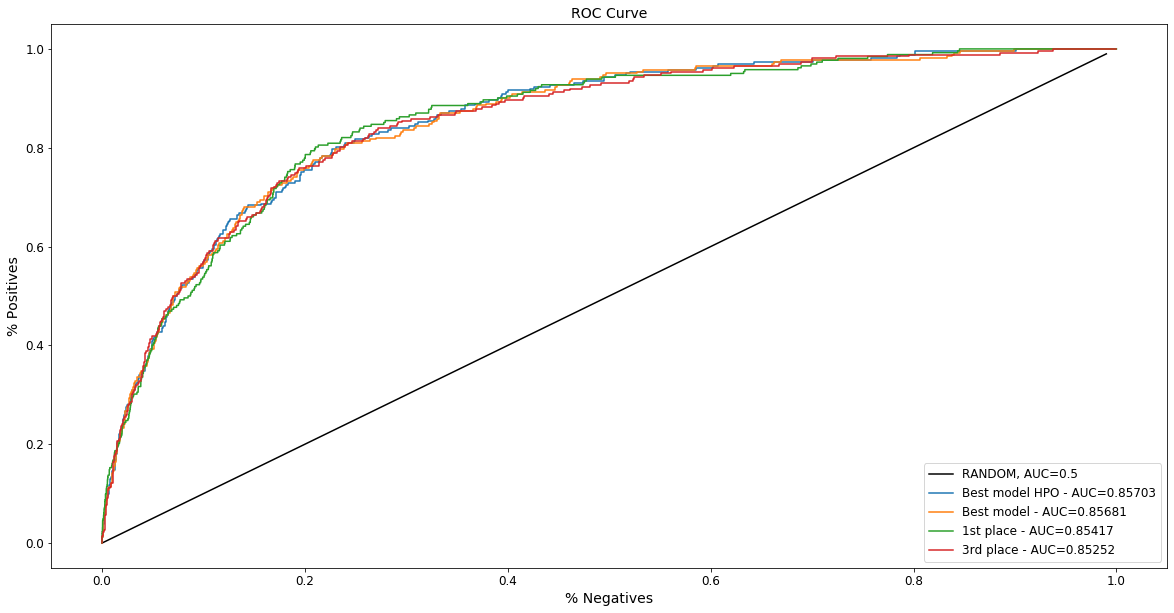

In [0]:
# Plot the ROC Curve for the 1st & 3rd places of the competition
cff.plot_roc_curves(y_truth, {"Best model HPO - AUC=0.85703": best_model_hpo, "Best model - AUC=0.85681": y_pred_best_model, "1st place - AUC=0.85417":y_pred_1st, "3rd place - AUC=0.85252":y_pred_3rd})